In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preparation

In [2]:
# loading full dataframe
final_df = pd.read_csv('final_df.csv')

In [3]:
# checking for null values
final_df.isna().sum()

title               1
artist              1
track_id            0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

In [4]:
# dropping duplicates
final_df.dropna(inplace=True)

In [5]:
# resetting index
final_df.reset_index(drop=True, inplace=True)

### Handling Data Imbalance Through Upsampling

In [6]:
genre_count = final_df['genre'].value_counts()
genre_count

house        1285
pop          1057
rock          995
country       747
metal         685
hiphop        680
techno        547
dance         522
jazz          487
kpop          397
classical     276
rnb           238
Name: genre, dtype: int64

In [7]:
# setting a minimum number of sample for each genre
min_genre_count = 800

In [8]:
# genres with samples more than min_genre_count
genre_count[genre_count > min_genre_count].index

Index(['house', 'pop', 'rock'], dtype='object')

In [9]:
# retaining data for genres with samples more than min_genre_count
genre_house = final_df[final_df['genre'] == 'house']
genre_pop = final_df[final_df['genre'] == 'pop']
genre_rock = final_df[final_df['genre'] == 'rock']

In [10]:
# genres with samples less than min_genre_count
genre_count[genre_count < min_genre_count].index

Index(['country', 'metal', 'hiphop', 'techno', 'dance', 'jazz', 'kpop',
       'classical', 'rnb'],
      dtype='object')

In [11]:
# upsampling data for genres with samples less than min_genre_count
genre_country = final_df[final_df['genre']=='country'].sample(min_genre_count, replace=True)
genre_metal = final_df[final_df['genre']=='metal'].sample(min_genre_count, replace=True)
genre_hiphop = final_df[final_df['genre']=='hiphop'].sample(min_genre_count, replace=True)
genre_techno = final_df[final_df['genre']=='techno'].sample(min_genre_count, replace=True)
genre_dance = final_df[final_df['genre']=='dance'].sample(min_genre_count, replace=True)
genre_jazz = final_df[final_df['genre']=='jazz'].sample(min_genre_count, replace=True)
genre_kpop = final_df[final_df['genre']=='kpop'].sample(min_genre_count, replace=True)
genre_classical = final_df[final_df['genre']=='classical'].sample(min_genre_count, replace=True)
genre_rnb = final_df[final_df['genre']=='rnb'].sample(min_genre_count, replace=True)

In [12]:
# concatetnating all genre dataframes after upsampling
upsampled_df = pd.concat([genre_house, genre_pop, genre_rock, genre_country, genre_metal, genre_hiphop, genre_techno, genre_dance, genre_jazz,  genre_kpop, genre_classical, genre_rnb], axis=0)

In [13]:
# computing supposed total numbers of tracks after upsampling
genre_count[genre_count > min_genre_count].values.sum()+len(genre_count[genre_count < min_genre_count].index)*min_genre_count

10537

In [14]:
# checking total numbers of tracks in new dataframe
len(upsampled_df)

10537

In [15]:
# resetting index
upsampled_df.reset_index(drop=True, inplace=True)

### Clustering
#### Scaling Data

In [16]:
# creating a dataframe for only audio features
X = upsampled_df.drop(columns=['title','artist', 'genre', 'track_id'])

In [17]:
# scaling the audio features dataframe
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.721,0.923,11,-4.497,0,0.0370,0.00299,0.03120,0.0989,0.575,128.748
1,0.805,0.660,5,-11.972,0,0.0897,0.01790,0.29500,0.3340,0.147,133.002
2,0.722,0.990,7,-5.103,1,0.0667,0.02090,0.00186,0.2620,0.398,122.991
3,0.691,0.830,0,-9.189,1,0.0450,0.06010,0.75800,0.4050,0.830,128.912
4,0.761,0.808,11,-5.629,0,0.0518,0.00258,0.00003,0.0869,0.157,119.931


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.613235,0.948721,1.576205,0.672510,-1.152434,-0.595531,-0.694172,-0.547726,-0.534296,0.287963,0.304847
1,1.083270,-0.052610,-0.102181,-0.577623,-1.152434,0.071641,-0.646450,0.214290,1.040812,-1.381529,0.462504
2,0.618831,1.203813,0.457281,0.571162,0.867729,-0.219535,-0.636848,-0.632478,0.558431,-0.402458,0.091487
3,0.445366,0.594638,-1.500837,-0.112189,0.867729,-0.494253,-0.511381,1.551716,1.516493,1.282637,0.310925
4,0.837061,0.510877,1.576205,0.483192,-1.152434,-0.408166,-0.695484,-0.637765,-0.614692,-1.342522,-0.021919


#### Elbow Method

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 

Training a K-Means model with 21 clusters! 

Training a K-Means model with 22 clusters! 

Training a K-Means model with 23 clusters! 

Training a K-Means model with 24 clusters! 

Training a K-Means model with 25 clusters! 

Training a K-Means model with 26 clusters! 

Training a K-Means model with 27 clusters! 

Training a K-Means model with 28 clusters! 

Training a K-Means model with 29 clusters! 

Training a K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

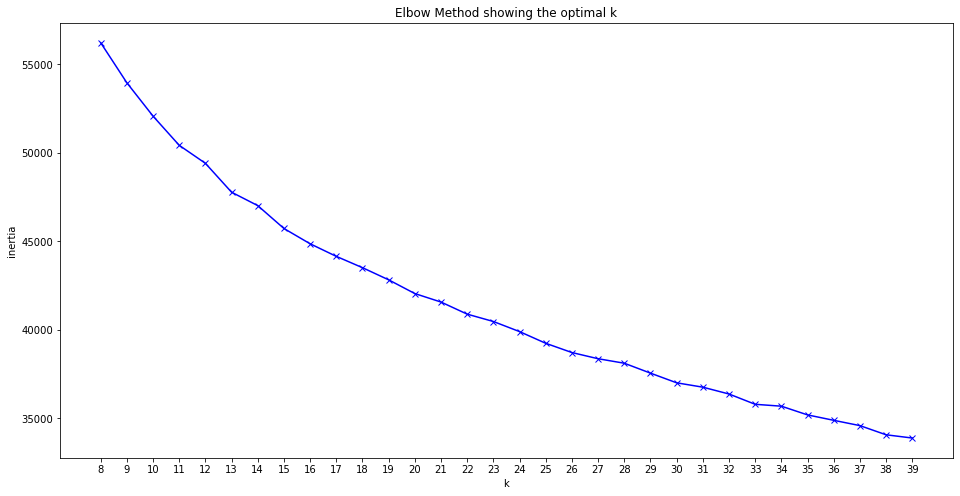

In [18]:
K = range(8, 40)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=345)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

#### Silhouette Method

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

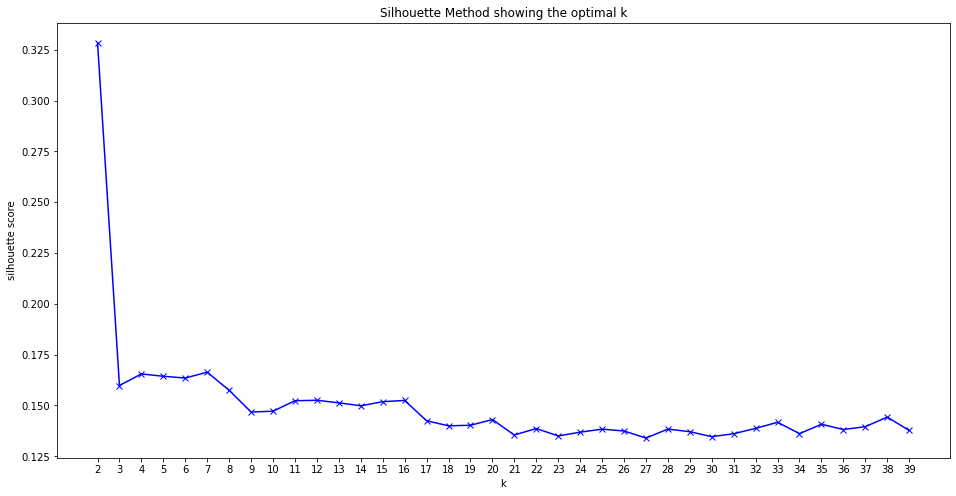

In [19]:
K = range(2, 40)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=345)
    kmeans.fit(X_scaled_df)
    
    filename = "Model/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

### Finalizing Database

In [20]:
# setting up clusters, using 16 based on Silhouette
kmeans = KMeans(n_clusters=16, random_state=345)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=16, random_state=345)

In [21]:
kmeans.inertia_

44866.51712420158

In [22]:
clusters = kmeans.predict(X_scaled_df)
pd.Series(clusters).value_counts().sort_index()

0      592
1      461
2      640
3      847
4      993
5      412
6     1107
7      264
8      814
9      520
10     735
11     639
12     695
13     608
14     741
15     469
dtype: int64

In [23]:
# integrating cluster into dataframe
upsampled_df['cluster'] = clusters

In [24]:
# saving the upsampled dataframe to a csv
from pathlib import Path  
filepath = Path('upsampled_df.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)
upsampled_df.to_csv(filepath, index=False)

In [25]:
# saving models
with open("Model/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)
with open("Model/kmeans.pickle", "wb") as f:
    pickle.dump(kmeans,f)